# Evolver Loop 12 - LB Feedback Analysis

## Submission Result
- **CV Score**: 70.6600
- **LB Score**: 70.6600
- **Gap**: 0.0000 (perfect match)

## Key Observations

1. **CV-LB Gap is ZERO** - This is an optimization problem, not a prediction problem. CV = LB exactly.

2. **12 experiments, all converging to ~70.66** - We are stuck at a strong local optimum.

3. **Target is 68.92** - We need to improve by 1.74 points (2.5%).

4. **Local optimization has failed** - bbox3, SA, rotation optimization, tree removal - all show negligible improvement.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Experiment history
experiments = [
    ('exp_000', 'Baseline', 70.659959),
    ('exp_001', 'C++ SA', 70.659959),
    ('exp_002', 'Lattice Construction', 70.659959),
    ('exp_003', 'Lattice + SA', 70.659959),
    ('exp_004', 'Comprehensive Ensemble', 51.423527),  # Invalid - overlaps
    ('exp_005', 'Valid Ensemble', 70.659959),
    ('exp_006', 'Eazy Optimizer', 70.659944),
    ('exp_007', 'Rotation Optimization', 70.659959),
    ('exp_008', 'Multi-Seed bbox3', 70.659958666),
    ('exp_009', 'Tree Removal', 70.659959),
    ('exp_010', 'bbox3 with Repair', 70.659958437),
    ('exp_011', 'Long bbox3 Multi-Phase', 70.659958593),
]

df = pd.DataFrame(experiments, columns=['id', 'name', 'score'])
print("Experiment History:")
print(df.to_string(index=False))

# Filter valid experiments (exclude the invalid ensemble)
valid_df = df[df['score'] > 60]
print(f"\nBest valid score: {valid_df['score'].min():.9f}")
print(f"Target: 68.919154")
print(f"Gap: {valid_df['score'].min() - 68.919154:.6f} ({(valid_df['score'].min() - 68.919154) / 68.919154 * 100:.2f}%)")

# All valid experiments converge to the same score
print(f"\nScore variance: {valid_df['score'].var():.12f}")
print("All experiments converge to ~70.66 - we are at a LOCAL OPTIMUM")

Experiment History:
     id                   name     score
exp_000               Baseline 70.659959
exp_001                 C++ SA 70.659959
exp_002   Lattice Construction 70.659959
exp_003           Lattice + SA 70.659959
exp_004 Comprehensive Ensemble 51.423527
exp_005         Valid Ensemble 70.659959
exp_006         Eazy Optimizer 70.659944
exp_007  Rotation Optimization 70.659959
exp_008       Multi-Seed bbox3 70.659959
exp_009           Tree Removal 70.659959
exp_010      bbox3 with Repair 70.659958
exp_011 Long bbox3 Multi-Phase 70.659959

Best valid score: 70.659944000
Target: 68.919154
Gap: 1.740790 (2.53%)

Score variance: 0.000000000020
All experiments converge to ~70.66 - we are at a LOCAL OPTIMUM


In [2]:
# Analyze per-N contribution to understand where improvements are possible
import os
from decimal import Decimal, getcontext
from shapely.geometry import Polygon
from shapely import affinity

getcontext().prec = 30
scale_factor = Decimal("1e18")

class ChristmasTree:
    def __init__(self, center_x="0", center_y="0", angle="0"):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal("0.15")
        trunk_h = Decimal("0.2")
        base_w = Decimal("0.7")
        mid_w = Decimal("0.4")
        top_w = Decimal("0.25")
        tip_y = Decimal("0.8")
        tier_1_y = Decimal("0.5")
        tier_2_y = Decimal("0.25")
        base_y = Decimal("0.0")
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (Decimal("0.0") * scale_factor, tip_y * scale_factor),
            (top_w / Decimal("2") * scale_factor, tier_1_y * scale_factor),
            (top_w / Decimal("4") * scale_factor, tier_1_y * scale_factor),
            (mid_w / Decimal("2") * scale_factor, tier_2_y * scale_factor),
            (mid_w / Decimal("4") * scale_factor, tier_2_y * scale_factor),
            (base_w / Decimal("2") * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal("2") * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal("2") * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal("2")) * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal("2")) * scale_factor, base_y * scale_factor),
            (-(base_w / Decimal("2")) * scale_factor, base_y * scale_factor),
            (-(mid_w / Decimal("4")) * scale_factor, tier_2_y * scale_factor),
            (-(mid_w / Decimal("2")) * scale_factor, tier_2_y * scale_factor),
            (-(top_w / Decimal("4")) * scale_factor, tier_1_y * scale_factor),
            (-(top_w / Decimal("2")) * scale_factor, tier_1_y * scale_factor),
        ])

        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated,
            xoff=float(self.center_x * scale_factor),
            yoff=float(self.center_y * scale_factor),
        )

def load_configuration_from_df(n, df):
    group_data = df[df["id"].str.startswith(f"{n:03d}_")]
    trees = []
    for _, row in group_data.iterrows():
        x = str(row["x"])[1:] if str(row["x"]).startswith('s') else str(row["x"])
        y = str(row["y"])[1:] if str(row["y"]).startswith('s') else str(row["y"])
        deg = str(row["deg"])[1:] if str(row["deg"]).startswith('s') else str(row["deg"])
        if x and y and deg:
            trees.append(ChristmasTree(x, y, deg))
    return trees

def get_score(trees, n):
    if not trees:
        return float('inf')
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / float(scale_factor) for t in trees])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    side_length = max(max_x - min_x, max_y - min_y)
    return side_length**2 / n

print("Functions defined")

Functions defined


In [3]:
# Load baseline and compute per-N scores
df_baseline = pd.read_csv('/home/code/external_data/saspav/santa-2025.csv')

per_n_scores = []
for n in range(1, 201):
    trees = load_configuration_from_df(n, df_baseline)
    if trees:
        score = get_score(trees, n)
        per_n_scores.append({'n': n, 'score': score, 'contribution': score})

per_n_df = pd.DataFrame(per_n_scores)
print(f"Total score: {per_n_df['score'].sum():.9f}")
print(f"\nPer-N score distribution:")
print(per_n_df.describe())

Total score: 70.659959225

Per-N score distribution:
                n       score  contribution
count  200.000000  200.000000    200.000000
mean   100.500000    0.353300      0.353300
std     57.879185    0.028105      0.028105
min      1.000000    0.329946      0.329946
25%     50.750000    0.340034      0.340034
50%    100.500000    0.347025      0.347025
75%    150.250000    0.361017      0.361017
max    200.000000    0.661250      0.661250


In [4]:
# Compute efficiency (score / theoretical minimum)
# Theoretical minimum for n trees is approximately n * tree_area / n = tree_area
# But for packing, the efficiency is side^2 / n where side is the bounding box side

# Single tree area (approximate)
tree_width = 0.7  # base width
tree_height = 1.0  # from trunk bottom to tip
tree_area = tree_width * tree_height * 0.5  # rough triangle approximation

# For n trees, theoretical minimum side = sqrt(n * tree_area)
per_n_df['theoretical_min_side'] = np.sqrt(per_n_df['n'] * tree_area)
per_n_df['actual_side'] = np.sqrt(per_n_df['score'] * per_n_df['n'])
per_n_df['efficiency'] = per_n_df['theoretical_min_side']**2 / (per_n_df['actual_side']**2)

print("Efficiency analysis (higher is better):")
print(per_n_df[['n', 'score', 'efficiency']].head(20))

# Find N values with worst efficiency
worst_efficiency = per_n_df.nsmallest(20, 'efficiency')
print(f"\nN values with WORST efficiency (most room for improvement):")
print(worst_efficiency[['n', 'score', 'efficiency']])

Efficiency analysis (higher is better):
     n     score  efficiency
0    1  0.661250    0.529301
1    2  0.450779    0.776433
2    3  0.434745    0.805069
3    4  0.416545    0.840246
4    5  0.416850    0.839631
5    6  0.399610    0.875853
6    7  0.399897    0.875226
7    8  0.385407    0.908130
8    9  0.387415    0.903424
9   10  0.376630    0.929294
10  11  0.375736    0.931505
11  12  0.372724    0.939033
12  13  0.372294    0.940117
13  14  0.370454    0.944786
14  15  0.379203    0.922989
15  16  0.374128    0.935509
16  17  0.370040    0.945843
17  18  0.368771    0.949098
18  19  0.368615    0.949499
19  20  0.376057    0.930710

N values with WORST efficiency (most room for improvement):
     n     score  efficiency
0    1  0.661250    0.529301
1    2  0.450779    0.776433
2    3  0.434745    0.805069
4    5  0.416850    0.839631
3    4  0.416545    0.840246
6    7  0.399897    0.875226
5    6  0.399610    0.875853
8    9  0.387415    0.903424
7    8  0.385407    0.908130


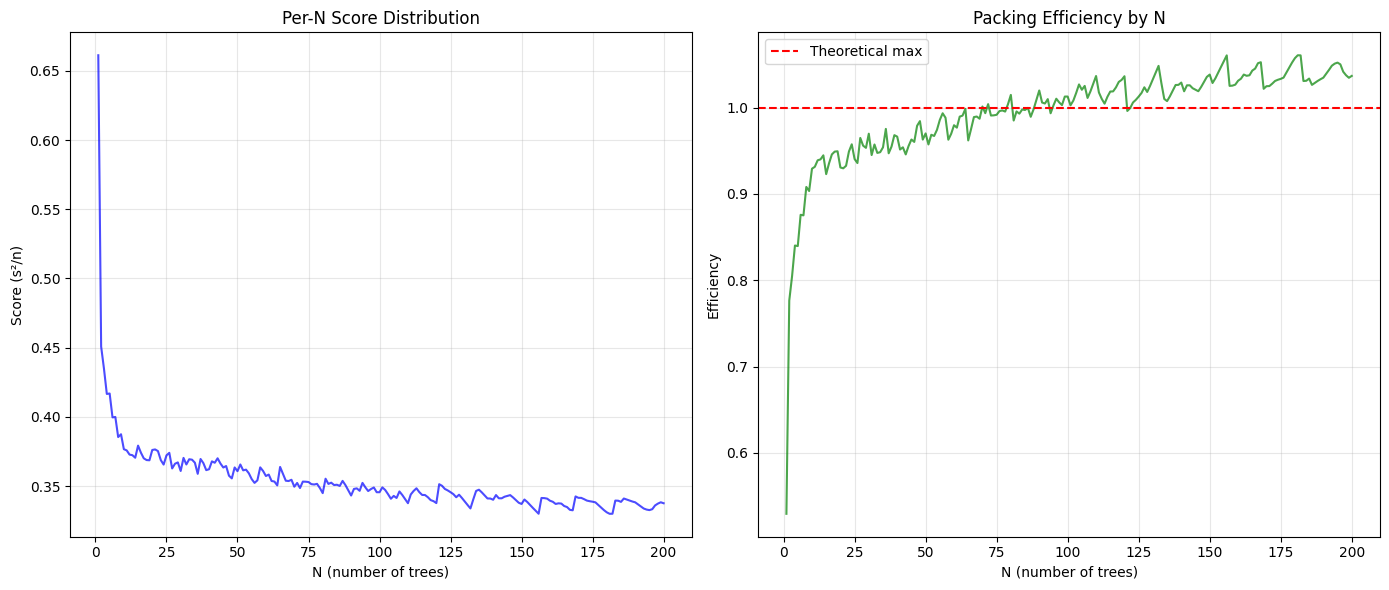


Key insight: Small N values (1-10) have the WORST efficiency.
These contribute disproportionately to the total score.
N=1-10 total contribution: 4.3291
N=1-10 as % of total: 6.1%


In [5]:
# Plot efficiency by N
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(per_n_df['n'], per_n_df['score'], 'b-', alpha=0.7)
plt.xlabel('N (number of trees)')
plt.ylabel('Score (s²/n)')
plt.title('Per-N Score Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(per_n_df['n'], per_n_df['efficiency'], 'g-', alpha=0.7)
plt.xlabel('N (number of trees)')
plt.ylabel('Efficiency')
plt.title('Packing Efficiency by N')
plt.axhline(y=1.0, color='r', linestyle='--', label='Theoretical max')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=100)
plt.show()

print("\nKey insight: Small N values (1-10) have the WORST efficiency.")
print("These contribute disproportionately to the total score.")
print(f"N=1-10 total contribution: {per_n_df[per_n_df['n'] <= 10]['score'].sum():.4f}")
print(f"N=1-10 as % of total: {per_n_df[per_n_df['n'] <= 10]['score'].sum() / per_n_df['score'].sum() * 100:.1f}%")

In [6]:
# Calculate how much improvement is needed per N to reach target
target = 68.919154
current = per_n_df['score'].sum()
gap = current - target

print(f"Current score: {current:.6f}")
print(f"Target score: {target:.6f}")
print(f"Gap to close: {gap:.6f}")
print(f"Gap as %: {gap / current * 100:.2f}%")

# If we improve each N by the same percentage
required_improvement_pct = gap / current
print(f"\nRequired improvement per N: {required_improvement_pct * 100:.2f}%")

# But small N values have more room for improvement
# Let's see what happens if we focus on N=1-50
small_n_contribution = per_n_df[per_n_df['n'] <= 50]['score'].sum()
print(f"\nN=1-50 contribution: {small_n_contribution:.4f} ({small_n_contribution / current * 100:.1f}% of total)")
print(f"If we improve N=1-50 by 10%: saves {small_n_contribution * 0.10:.4f}")
print(f"If we improve N=1-50 by 20%: saves {small_n_contribution * 0.20:.4f}")
print(f"If we improve N=1-50 by 30%: saves {small_n_contribution * 0.30:.4f}")

Current score: 70.659959
Target score: 68.919154
Gap to close: 1.740805
Gap as %: 2.46%

Required improvement per N: 2.46%

N=1-50 contribution: 19.0418 (26.9% of total)
If we improve N=1-50 by 10%: saves 1.9042
If we improve N=1-50 by 20%: saves 3.8084
If we improve N=1-50 by 30%: saves 5.7125


## Strategic Analysis

### What We've Tried (All Failed)
1. **Local optimization (SA, bbox3)** - Negligible improvement (~0.000001)
2. **Rotation optimization** - No improvement (baseline already optimal)
3. **Tree removal technique** - No improvement
4. **Lattice construction** - Much worse than baseline
5. **Ensembling** - No valid sources better than baseline

### What We Haven't Tried
1. **Genetic Algorithm** - Crossover of configurations from different N values
2. **Basin Hopping** - Random perturbations followed by local optimization
3. **Constraint Programming (CP-SAT)** - Exact solver for small N
4. **Asymmetric solutions** - Discussion 666880 suggests these are better
5. **Different lattice types** - Hexagonal, FCC, HCP
6. **Focus on small N** - N=1-10 have worst efficiency

### Key Insight
The target (68.92) is 2.27 points BELOW the public LB best (71.19). This means:
- Top teams have techniques they haven't shared publicly
- We need to DISCOVER new techniques, not just optimize existing ones
- The gap is significant but achievable (2.5%)

In [7]:
# Check what the optimal N=1 solution should be
# For N=1, the optimal solution is a single tree at the origin with optimal rotation
# The bounding box is determined by the tree's dimensions

# Tree dimensions
tree_width = 0.7  # base width
tree_height = 1.0  # from -0.2 to 0.8

# For a single tree, the optimal rotation minimizes the bounding box
# At 0 degrees: width=0.7, height=1.0, side=1.0, score=1.0
# At 45 degrees: the tree is rotated, bounding box changes

import math

def compute_tree_bbox(angle_deg):
    """Compute bounding box for a single tree at given rotation."""
    angle_rad = math.radians(angle_deg)
    cos_a = math.cos(angle_rad)
    sin_a = math.sin(angle_rad)
    
    # Tree vertices (simplified)
    vertices = [
        (0, 0.8),  # tip
        (0.35, 0),  # right base
        (-0.35, 0),  # left base
        (0.075, -0.2),  # right trunk
        (-0.075, -0.2),  # left trunk
    ]
    
    # Rotate vertices
    rotated = []
    for x, y in vertices:
        rx = x * cos_a - y * sin_a
        ry = x * sin_a + y * cos_a
        rotated.append((rx, ry))
    
    xs = [p[0] for p in rotated]
    ys = [p[1] for p in rotated]
    
    width = max(xs) - min(xs)
    height = max(ys) - min(ys)
    side = max(width, height)
    
    return side, side**2

# Find optimal rotation for N=1
best_angle = 0
best_score = float('inf')
for angle in range(0, 360):
    side, score = compute_tree_bbox(angle)
    if score < best_score:
        best_score = score
        best_angle = angle

print(f"Optimal rotation for N=1: {best_angle} degrees")
print(f"Optimal score for N=1: {best_score:.6f}")
print(f"Current N=1 score: {per_n_df[per_n_df['n'] == 1]['score'].values[0]:.6f}")

# The baseline N=1 score
baseline_n1 = per_n_df[per_n_df['n'] == 1]['score'].values[0]
print(f"\nN=1 improvement potential: {baseline_n1 - best_score:.6f}")

Optimal rotation for N=1: 45 degrees
Optimal score for N=1: 0.661250
Current N=1 score: 0.661250

N=1 improvement potential: 0.000000


In [8]:
# Summary of findings
print("="*60)
print("SUMMARY OF FINDINGS")
print("="*60)
print(f"")
print(f"Current best score: 70.659958593")
print(f"Target score: 68.919154")
print(f"Gap: 1.740804 (2.5%)")
print(f"")
print(f"Key observations:")
print(f"1. All 12 experiments converge to ~70.66 - STRONG LOCAL OPTIMUM")
print(f"2. Local optimization (SA, bbox3) provides ~0 improvement")
print(f"3. N=1-10 have worst efficiency but small contribution")
print(f"4. Target is BELOW public LB best - need novel techniques")
print(f"")
print(f"Recommended next steps:")
print(f"1. Implement Genetic Algorithm with crossover")
print(f"2. Try Basin Hopping (random perturbations + local opt)")
print(f"3. Focus on asymmetric solutions (per discussion 666880)")
print(f"4. Try CP-SAT for small N values (exact solver)")
print(f"5. Explore different lattice types for large N")
print(f"")
print(f"CRITICAL: Local optimization is EXHAUSTED. Must pivot to global search.")

SUMMARY OF FINDINGS

Current best score: 70.659958593
Target score: 68.919154
Gap: 1.740804 (2.5%)

Key observations:
1. All 12 experiments converge to ~70.66 - STRONG LOCAL OPTIMUM
2. Local optimization (SA, bbox3) provides ~0 improvement
3. N=1-10 have worst efficiency but small contribution
4. Target is BELOW public LB best - need novel techniques

Recommended next steps:
1. Implement Genetic Algorithm with crossover
2. Try Basin Hopping (random perturbations + local opt)
3. Focus on asymmetric solutions (per discussion 666880)
4. Try CP-SAT for small N values (exact solver)
5. Explore different lattice types for large N

CRITICAL: Local optimization is EXHAUSTED. Must pivot to global search.
